###  Введение

В ходе исследования мы загрузим данные (тексты песен) при помощи парсинга сайта, проведем обработку текстов, а также проанализируем тексты на совпадения. По итогу будет создано облако из наиболее часто встречающихся слов в текстах.

In [ ]:
from bs4 import BeautifulSoup as bs
import requests

import matplotlib.pyplot as plt
import pandas as pd # Библиотека для работы с таблицами
import numpy as np  # Библиотека для работы с массивами и матрицами
import nltk # Библиотека для работы с текстами
from nltk.tokenize import word_tokenize, sent_tokenize # токенайзер - разбивает непрерывный текст на токены(слова)
from nltk.stem.snowball import SnowballStemmer # стеммер - преобразует тексты к начальной форме
from nltk.corpus import stopwords # список незначимых слов - я, ты, он, она, там и тд
nltk.download('all')
nltk.download('punkt')
nltk.download('stopwords')

from wordcloud import WordCloud

#### Напишем небольшую функцию- парсер для загрузки текстов песен
Будем загружать с сайта https://txt-pesen.ru тексты песен 3-х известных рок-групп: Ария, Пикник и Наутилус Помпилиус.

In [2]:
def parser(url):
    
    response = requests.get(url, params='')
    soup = bs(response.content, 'html.parser')
    text = ''
    songs = soup.find_all('tr', class_ = 'cat-list-row0')

    for i in songs:
        page = i.find('td', class_="list-title").find('a').get('href') 
        url = 'https://txt-pesen.ru/' + str(page)
        response = requests.get(url, params='')
        soup = bs(response.content, 'html.parser')
        song = soup.find('div',itemprop="articleBody").get_text()
        song = song[:-70]
        text = text + song
    return text

        # with open('nautilus.csv', 'w') as file: # для сохранения в файл
        #     file.write(nautilus)
        
url = 'https://txt-pesen.ru/russkij-rok/nautiluspompilius.html' 
url2 = 'https://txt-pesen.ru/russkij-rok/piknik.html' 
url3 = 'https://txt-pesen.ru/russkij-rok/arija.html' 
# url = input('Скопируйте и вставьте адрес с главной страницы исполнителя') # вариант для самостоятельного выбора пользователем
            
nautilus = parser(url)
picnic = parser(url2)
aria = parser(url3)

In [3]:
len(aria) # проверим  длину загруженной строки

66980

In [4]:
aria[-210:-1] # проверим, что загрузили на примере  группы Ария. Все верно - песня точно их;)

'.\n\r\nЯ - свободен, словно птица в небесах.\r\nЯ - свободен! Я забыл, что значит страх.\r\nЯ - свободен, с диким ветром - наравне.\r\nЯ - свободен, наяву, а не во сне.\n\r\nЯ - свободен!\r\nЯ - свободен!\r\nЯ - свободен!\n\n\n\n'

Обработка  текста будет происходить при помощи функции, которая  принимает на вход текст и возвращает леммы токенов предложения, фильтруя по стоп-словам и удаляя знаки пунктуации.

In [5]:
# для удаления знаков пунктуации
import string
punctuations = list(string.punctuation)

In [6]:
# set нужен для того, чтобы поиск по словам был быстрее
from nltk.corpus import stopwords
ru_stop_words = set(stopwords.words('russian'))

In [7]:
# к данному списку можно добавлять свои слова,  мешающие работе алгоритма 
my_stop_words = ['поэтому', 'припев', 'это','куплет', '.прип','прип','...','пикник','ария','наутилус','помпилиус','песня','тво','сво']
ru_stop_words.update(my_stop_words)

In [8]:
#  Данная функция принимает на вход текст и возвращает леммы токенов предложения, фильтруя по стоп-словам и удаляя знаки пунктуации
def text_processing(text, stemmer, stop_words, punct):
    text = text.lower()
    words = word_tokenize(text) # С помощью токенизации разбиваем текст на токены 
    words = [word for word in words if word not in ru_stop_words] # Удаляем стопслова
    words = [word for word in words if word not in punct] # Удаляем знаки пунктуации
    
    words = [stemmer.stem(word) for word in words] # стеммируем каждое слово
    new_text = ','.join(words)
    return new_text

In [9]:
stemmer_ru = SnowballStemmer("russian")

In [10]:
nautilus_stemmed_text = text_processing(nautilus, stemmer_ru, ru_stop_words, punctuations)
picnic_stemmed_text = text_processing(picnic, stemmer_ru, ru_stop_words, punctuations)
aria_stemmed_text = text_processing(aria, stemmer_ru, ru_stop_words, punctuations)

Проверим результат работы функции сравним длину текста до и после обработки

In [11]:
len(nautilus)

53027

In [12]:
len(nautilus_stemmed_text)

34131

Как видно  функция работает - количество лишних знаков в тексте уменьшилось значительно

Теперь посмотрим насколько отличаются тексты у данных исполнителей, для этого импортируем библиотеку difflib

In [13]:
import difflib

texts_list = [nautilus_stemmed_text,picnic_stemmed_text,aria_stemmed_text]
all_texts2 = ['Наутилус','Пикник','Ария']

def similarity(text1, text2):

  matcher = difflib.SequenceMatcher(None, text1, text2)
  return matcher.ratio()

for i in range(0, len(texts_list)):
    for j in range(i+1, len(texts_list)):
        if i != j:
            print('Совпадение текстов', all_texts2[i], '-',all_texts2[j], (similarity(texts_list[i], texts_list[j]))*100, '%')

Совпадение текстов Наутилус - Пикник 0.2542125422971882 %
Совпадение текстов Наутилус - Ария 0.43537064468345466 %
Совпадение текстов Пикник - Ария 0.4734288081429755 %


Как видим тексты сильно отличаются - совпадение составило менее 1%

In [14]:
# Объединим данные всех исполнителей для определения наиболее часто встречающихся слов
all_texts = nautilus_stemmed_text + picnic_stemmed_text + aria_stemmed_text
all_texts_tokens = word_tokenize(all_texts)
df_all_texts= pd.DataFrame(all_texts_tokens)
df_all_texts.rename(columns = {0 : 'word'}, inplace = True)

In [15]:
# Добавим столбец
df_all_texts['count'] = df_all_texts['word']

In [16]:
df_all_texts_count = df_all_texts[df_all_texts['count'] != ','].groupby('word').count().sort_values('count',ascending=False).head(60)

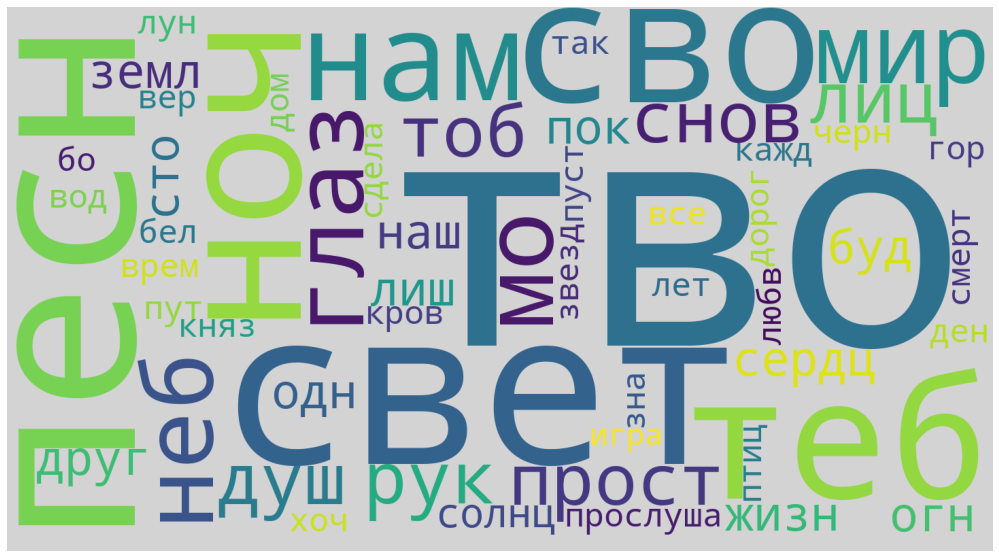

In [18]:
# Построим облако слов из наиболее часто встречающихся слов у данных исполнителей
wordcloud = WordCloud(background_color = 'lightgray',
                      height =800,
                      width = 1450
                     ).generate(str(df_all_texts_count)[20:])
plt.rcParams['figure.figsize'] = (20,10)
plt.axis("off")
plt.imshow(wordcloud)
# plt.title("...",fontsize=26, y=1.02)
plt.show()

#### Выводы
Код полностью работоспособен, с учётом небольших доработок в части добавления опции выбора пользователем исполнителя возможна интеграция данного кода в приложение для использования широким кругом пользователей.